<a href="https://colab.research.google.com/drive/1uEc4FCWNqkeWFHMMo0emi8w_Op4WOfUY#scrollTo=view-in-github" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 4 Project: Detecting Pneumonia in Chest X-Rays using Convolutional Neural Networks

Muhammad Qayyum
(wajeeh853@icloud.com)

Saad Raees
(saadraees09@gmail.com)





In [ ]:
from tensorflow.random import set_seed
set_seed(321)

import numpy as np
np.random.seed(123)

In [ ]:
!pip install lime

In [ ]:
# Import Statements
import os
import glob
from google.colab import drive

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

### Uploading the Data

In [ ]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', '.ipynb_checkpoints', 'old_chest_xray', 'sample_data']


In [ ]:
# Location of Zip File
drive_path = '/gdrive/MyDrive/Data/pneumonia_data.zip'
local_path = '/content'

In [ ]:
!cp '{drive_path}' .

In [ ]:
os.chdir(local_path)
!unzip -q 'pneumonia_data.zip'

## Data Preprocessing and Exploration
- Obtain and Store the Data in a train / test / val split
- Scale data
- Explore the data
  - check for class imbalance
  - look at images

In [ ]:
# File Paths
path_train_pneumonia = '/content/chest_xray/train/PNEUMONIA'
path_train_normal = '/content/chest_xray/train/NORMAL'
path_test_pneumonia = '/content/chest_xray/test/PNEUMONIA'
path_test_normal = '/content/chest_xray/test/NORMAL'
path_val_pneumonia = '/content/chest_xray/val/PNEUMONIA'
path_val_normal = '/content/chest_xray/val/NORMAL'

# How many images in each set
print('Train Pneumonia', len(os.listdir(path_train_pneumonia)))
print('Train Normal', len(os.listdir(path_train_normal)))
print('Test Pneumonia', len(os.listdir(path_test_pneumonia)))
print('Test Normal', len(os.listdir(path_test_normal)))
print('Val Pneumonia', len(os.listdir(path_val_pneumonia)))
print('Val Normal', len(os.listdir(path_val_normal)))

Train Pneumonia 3875
Train Normal 1341
Test Pneumonia 390
Test Normal 234
Val Pneumonia 8
Val Normal 8


In [ ]:
# Create data generators
# Ensure class_mode is binary
# Use batch size based on our above findings
# Use a target size of 224x224 px for each image
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/chest_xray/train',
                                                     target_size=(224, 224),
                                                     batch_size=5216,
                                                     class_mode='binary',
                                                     seed=123)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/chest_xray/test',
                                                     target_size=(224, 224),
                                                     batch_size=624,
                                                     class_mode='binary',
                                                     seed=123)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/chest_xray/val',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='binary',
                                                     seed=123)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# Create the data sets with the train/test/val splits
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [ ]:
# Check our y_train and which classes are which
print(y_train[:20])
print(y_train.shape)
train_generator.class_indices

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
(5216,)


{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Check shapes of the image data
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5216, 224, 224, 3)
(624, 224, 224, 3)
(16, 224, 224, 3)


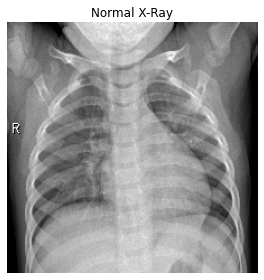

0.0


In [ ]:
# What does a normal image look like?
plt.imshow(np.squeeze(X_train[0]))
plt.axis('off')
plt.title('Normal X-Ray')
plt.tight_layout()
plt.show()
# Check the class label ('Normal':0)
print(y_train[0])

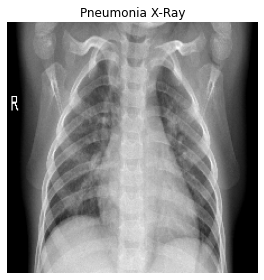

1.0


In [ ]:
# What does a pneumonia xray look like?
plt.imshow(np.squeeze(X_train[1]))
plt.axis('off')
plt.title('Pneumonia X-Ray')
plt.tight_layout()
plt.show()
# Check class label ('Pneumonia':1)
print(y_train[1])

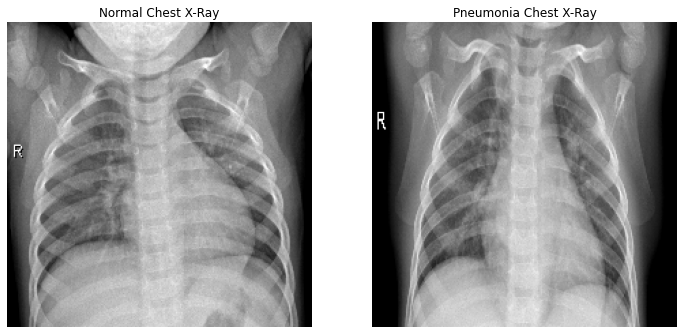

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(np.squeeze(X_train[0]))
axes[1].imshow(np.squeeze(X_train[1]))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Normal Chest X-Ray')
axes[1].set_title('Pneumonia Chest X-Ray')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


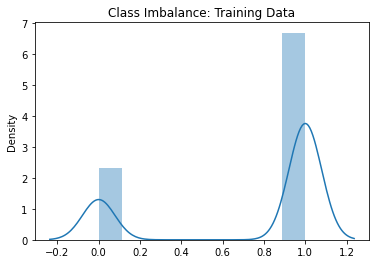

In [ ]:
# Look at class imbalance of training data
sns.distplot(y_train)
plt.title('Class Imbalance: Training Data')
plt.show()

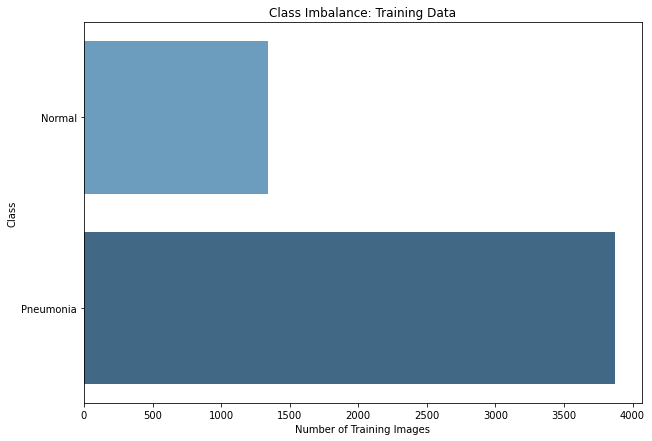

In [ ]:
# Make a prettier visual
plt.figure(figsize=(10,7))
sns.barplot(x=[sum(y_train==0), sum(y_train==1)],
            y=['Normal', 'Pneumonia'],
            palette='Blues_d')
plt.title('Class Imbalance: Training Data')
plt.ylabel('Class')
plt.xlabel('Number of Training Images')
plt.show()

# Baseline CNN
- Baseline model with 3 convolutional layers, 3 max pooling layers, and one fully connected layer

In [ ]:
baseline = models.Sequential()

baseline.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Conv2D(32, (3, 3), activation='relu'))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Conv2D(64, (3, 3), activation='relu'))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Flatten())
baseline.add(Dense(64, activation='relu'))
baseline.add(Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [ ]:
# Look at summary to see all layers
baseline.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 43264)            

In [ ]:
history = baseline.fit(X_train,
                       y_train,
                       epochs=20,
                       batch_size=50,
                       validation_data=(X_val, y_val))

Epoch 1/20
105/105 [==============================] - 3s 33ms/step - loss: 0.2644 - acc: 0.8930 - val_loss: 0.2976 - val_acc: 0.8750
Epoch 2/20
105/105 [==============================] - 3s 32ms/step - loss: 0.1165 - acc: 0.9542 - val_loss: 1.0070 - val_acc: 0.6875
Epoch 3/20
105/105 [==============================] - 3s 32ms/step - loss: 0.0966 - acc: 0.9661 - val_loss: 0.2185 - val_acc: 0.8750
Epoch 4/20
105/105 [==============================] - 3s 32ms/step - loss: 0.0674 - acc: 0.9780 - val_loss: 0.1807 - val_acc: 0.9375
Epoch 5/20
105/105 [==============================] - 3s 32ms/step - loss: 0.0573 - acc: 0.9816 - val_loss: 0.5551 - val_acc: 0.6875
Epoch 6/20
105/105 [==============================] - 3s 32ms/step - loss: 0.0539 - acc: 0.9803 - val_loss: 0.2196 - val_acc: 0.9375
Epoch 7/20
105/105 [==============================] - 3s 32ms/step - loss: 0.0395 - acc: 0.9873 - val_loss: 0.4818 - val_acc: 0.8125
Epoch 8/20
105/105 [==============================] - 3s 32ms/step - 

In [ ]:
def evaluate_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test < thresh).astype(np.int)
  y_true = y_test.astype(np.int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actuals')
  plt.title('Model Confusion Matrix')
  plt.show()

  print(classification_report(y_true, y_pred))
  print('\n')

  test_loss, test_acc = results.model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

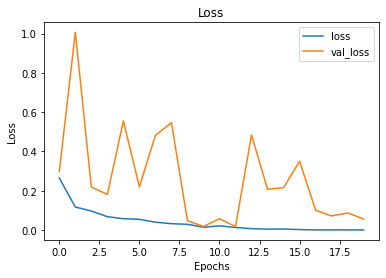

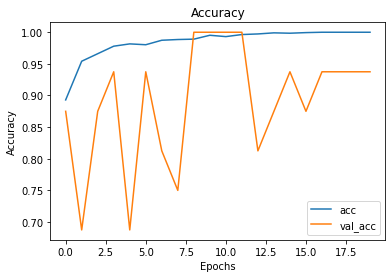

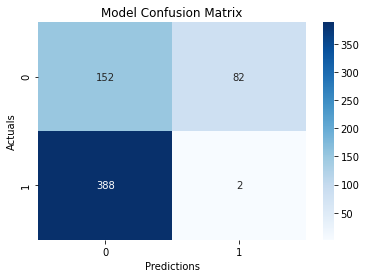

              precision    recall  f1-score   support

           0       0.28      0.65      0.39       234
           1       0.02      0.01      0.01       390

    accuracy                           0.25       624
   macro avg       0.15      0.33      0.20       624
weighted avg       0.12      0.25      0.15       624



20/20 [==============================] - 0s 10ms/step - loss: 3.7485 - acc: 0.7532
Test Loss: 3.748461961746216
Test Acc: 0.7532051205635071


In [ ]:
evaluate_results(history)

**Evaluation**

This model is not great. It is mostly predicting that there is no pneumonia. This could be due to class imbalance. We can also see that the validation curves are very spiky before convergence, which could be due to the small validation set. 

This model might be fixed with an early stopping callback. The model is also overfit quite a bit, so that would be another reason to include the early stopping, and possibly a learning rate reduction callback as well. I will use these changes in the model's second iteration.

# Iteration 2
- Address the class imbalance using class weights
  - based on the results of the baseline model's confusion matrix, which shows the model is predicting mostly one class
- Experiment with more epochs and early stopping
  - might prevent overfitting
- Reduce batch size
  - might improve accuracy

In [ ]:
# Set up out class weights
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
weights_dict = dict(zip(np.unique(y_train), weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [ ]:
# Set up early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr_redox = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [early_stop, lr_redox]

In [ ]:
# Build model iteration 2 with improvements above and another conv layer
mod2 = models.Sequential()

mod2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod2.add(MaxPooling2D((2, 2)))

mod2.add(Conv2D(32, (3, 3), activation='relu'))
mod2.add(MaxPooling2D(2, 2))

mod2.add(Conv2D(64, (3, 3), activation='relu'))
mod2.add(MaxPooling2D((2, 2)))

mod2.add(Flatten())
mod2.add(Dense(64, activation='relu'))
mod2.add(Dense(1, activation='sigmoid'))

mod2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [ ]:
mod2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 43264)            

In [ ]:
results = mod2.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=30,
                   validation_data=(X_val, y_val),
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/50
174/174 [==============================] - 4s 21ms/step - loss: 0.3497 - acc: 0.8455 - val_loss: 0.3110 - val_acc: 0.8125
Epoch 2/50
174/174 [==============================] - 4s 21ms/step - loss: 0.1121 - acc: 0.9567 - val_loss: 0.2046 - val_acc: 0.8750
Epoch 3/50
174/174 [==============================] - 4s 21ms/step - loss: 0.1006 - acc: 0.9641 - val_loss: 0.0843 - val_acc: 1.0000
Epoch 4/50
174/174 [==============================] - 4s 21ms/step - loss: 0.0703 - acc: 0.9732 - val_loss: 0.1104 - val_acc: 1.0000
Epoch 5/50
174/174 [==============================] - 4s 21ms/step - loss: 0.0669 - acc: 0.9737 - val_loss: 0.1053 - val_acc: 0.9375
Epoch 6/50
174/174 [==============================] - 4s 21ms/step - loss: 0.0562 - acc: 0.9774 - val_loss: 0.0416 - val_acc: 1.0000
Epoch 7/50
174/174 [==============================] - 4s 21ms/step - loss: 0.0438 - acc: 0.9827 - val_loss: 0.0941 - val_acc: 0.9375
Epoch 8/50
174/174 [==============================] - 4s 21ms/step - 

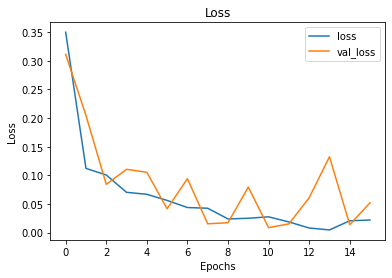

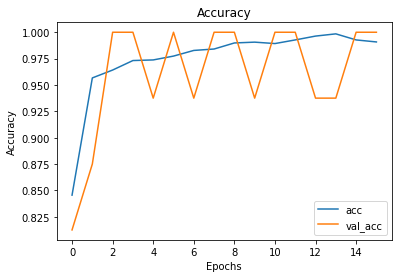

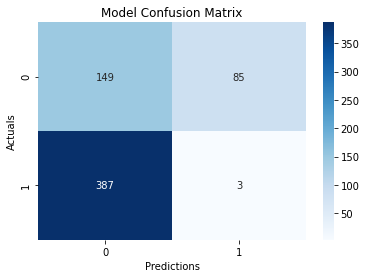

              precision    recall  f1-score   support

           0       0.28      0.64      0.39       234
           1       0.03      0.01      0.01       390

    accuracy                           0.24       624
   macro avg       0.16      0.32      0.20       624
weighted avg       0.13      0.24      0.15       624



20/20 [==============================] - 0s 10ms/step - loss: 2.7560 - acc: 0.7564
Test Loss: 2.756023406982422
Test Acc: 0.7564102411270142


In [ ]:
evaluate_results(results)

**Evaluation**

Not much improvement here. The loss did go down a bit but accuracy is roughly the same. 

It is clear that the validation curves are not easily converging, which I believe might be due to their tiny size. The validation set here is only 16 images, while the training set is over 5000... Therefore, in the next iteration, I will try to rework that validation training split within the model fitting params instead of using the tiny validation set provided.

# Iteration 3
- Going off of iteration 2, I will try to rework the validation set size to see if it makes any improvements in the loss and accuracy curves.

In [ ]:
mod3 = models.Sequential()

mod3.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod3.add(MaxPooling2D((2, 2)))

mod3.add(Conv2D(32, (3, 3), activation='relu'))
mod3.add(MaxPooling2D(2, 2))

mod3.add(Conv2D(64, (3, 3), activation='relu'))
mod3.add(MaxPooling2D((2, 2)))

mod3.add(Flatten())
mod3.add(Dense(64, activation='relu'))
mod3.add(Dense(1, activation='sigmoid'))

mod3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [ ]:
results = mod3.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=30,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/50
140/140 [==============================] - 3s 24ms/step - loss: 0.3415 - acc: 0.8408 - val_loss: 0.2201 - val_acc: 0.9071
Epoch 2/50
140/140 [==============================] - 3s 23ms/step - loss: 0.1243 - acc: 0.9549 - val_loss: 0.0926 - val_acc: 0.9674
Epoch 3/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0966 - acc: 0.9676 - val_loss: 0.1423 - val_acc: 0.9531
Epoch 4/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0786 - acc: 0.9705 - val_loss: 0.1009 - val_acc: 0.9665
Epoch 5/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0639 - acc: 0.9777 - val_loss: 0.0662 - val_acc: 0.9741
Epoch 6/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0528 - acc: 0.9799 - val_loss: 0.0606 - val_acc: 0.9808
Epoch 7/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0508 - acc: 0.9799 - val_loss: 0.0938 - val_acc: 0.9693
Epoch 8/50
140/140 [==============================] - 3s 23ms/step - 

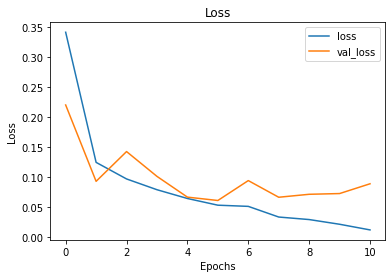

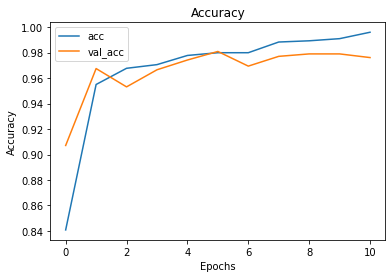

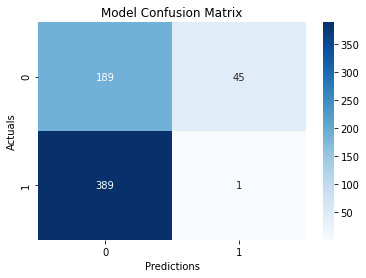

              precision    recall  f1-score   support

           0       0.33      0.81      0.47       234
           1       0.02      0.00      0.00       390

    accuracy                           0.30       624
   macro avg       0.17      0.41      0.24       624
weighted avg       0.14      0.30      0.18       624



20/20 [==============================] - 0s 10ms/step - loss: 2.5968 - acc: 0.6955
Test Loss: 2.596813678741455
Test Acc: 0.6955128312110901


In [ ]:
evaluate_results(results)

Try the same as iteration 2 but with 2 convolutional layers per block. Also try another optimizer ('RMSprop')

In [ ]:
mod3a = models.Sequential()

mod3a.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod3a.add(Conv2D(32, (3, 3), activation='relu'))
mod3a.add(MaxPooling2D((2, 2)))

mod3a.add(Conv2D(32, (3, 3), activation='relu'))
mod3a.add(Conv2D(32, (3, 3), activation='relu'))
mod3a.add(MaxPooling2D(2, 2))

mod3a.add(Conv2D(64, (3, 3), activation='relu'))
mod3a.add(Conv2D(64, (3, 3), activation='relu'))
mod3a.add(MaxPooling2D((2, 2)))

mod3a.add(Flatten())
mod3a.add(Dense(64, activation='relu'))
mod3a.add(Dense(1, activation='sigmoid'))

mod3a.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
results = mod3a.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=30,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])

Epoch 1/50
140/140 [==============================] - 7s 48ms/step - loss: 0.5880 - acc: 0.7651 - val_loss: 0.1759 - val_acc: 0.9416
Epoch 2/50
140/140 [==============================] - 7s 47ms/step - loss: 0.2793 - acc: 0.9104 - val_loss: 0.2835 - val_acc: 0.8994
Epoch 3/50
140/140 [==============================] - 7s 47ms/step - loss: 0.1477 - acc: 0.9437 - val_loss: 0.1351 - val_acc: 0.9607
Epoch 4/50
140/140 [==============================] - 7s 48ms/step - loss: 0.1328 - acc: 0.9530 - val_loss: 0.0990 - val_acc: 0.9722
Epoch 5/50
140/140 [==============================] - 7s 47ms/step - loss: 0.1004 - acc: 0.9652 - val_loss: 0.0821 - val_acc: 0.9741
Epoch 6/50
140/140 [==============================] - 7s 47ms/step - loss: 0.1165 - acc: 0.9734 - val_loss: 0.0874 - val_acc: 0.9780
Epoch 7/50
140/140 [==============================] - 7s 47ms/step - loss: 0.0639 - acc: 0.9777 - val_loss: 0.1441 - val_acc: 0.9607
Epoch 8/50
140/140 [==============================] - 7s 48ms/step - 

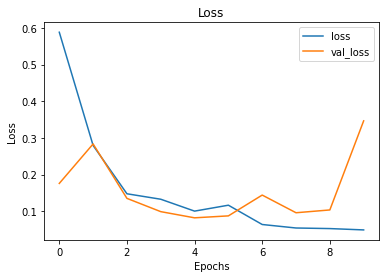

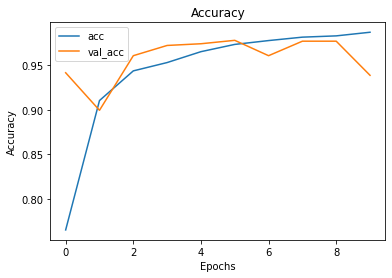

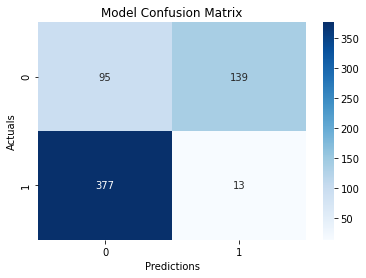

              precision    recall  f1-score   support

           0       0.20      0.41      0.27       234
           1       0.09      0.03      0.05       390

    accuracy                           0.17       624
   macro avg       0.14      0.22      0.16       624
weighted avg       0.13      0.17      0.13       624



20/20 [==============================] - 0s 15ms/step - loss: 1.0873 - acc: 0.8269
Test Loss: 1.0872985124588013
Test Acc: 0.8269230723381042


In [ ]:
evaluate_results(results)

**Evaluation**

The test set did not actually improve much here but these curves look MUCH better. Model 3a improved a bit here. Therefore, in future iterations, I will keep this validation split instead of using the tiny validation set.

# Iteration 4
- In this iteration, I want to experiment with a more complicated architecture
  - adding 2 convolutional layers per max pooling layer
  - when researching different successful image classification with xrays, this seemed to be a common practice
  - Since the previous models keep predicting mostly non-pneumonia, I think that adding more convolutional layers will help detect more of the edges/nuances in the images with pneumonia

- I will also add another 2 blocks of layers
  - AKA making the model deeper

- Continue using 'RMSprop' as the optimizer

In [ ]:
mod4 = models.Sequential()

mod4.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod4.add(Conv2D(32, (3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Conv2D(32, (3, 3), activation='relu'))
mod4.add(Conv2D(32, (3, 3), activation='relu'))
mod4.add(MaxPooling2D(2, 2))

mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Flatten())
mod4.add(Dense(128, activation='relu'))
mod4.add(Dense(64, activation='relu'))
mod4.add(Dense(1, activation='sigmoid'))

mod4.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
mod4.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 108, 108, 32)      9248      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 106, 106, 32)      9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 51, 51, 64)      

In [ ]:
results = mod4.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])

Epoch 1/50
131/131 [==============================] - 7s 52ms/step - loss: 0.7168 - acc: 0.6110 - val_loss: 0.2889 - val_acc: 0.8784
Epoch 2/50
131/131 [==============================] - 7s 51ms/step - loss: 0.3942 - acc: 0.8459 - val_loss: 0.1806 - val_acc: 0.9186
Epoch 3/50
131/131 [==============================] - 7s 51ms/step - loss: 0.2622 - acc: 0.9147 - val_loss: 0.1653 - val_acc: 0.9330
Epoch 4/50
131/131 [==============================] - 7s 51ms/step - loss: 0.1824 - acc: 0.9334 - val_loss: 0.1087 - val_acc: 0.9598
Epoch 5/50
131/131 [==============================] - 7s 51ms/step - loss: 0.1456 - acc: 0.9533 - val_loss: 0.1035 - val_acc: 0.9617
Epoch 6/50
131/131 [==============================] - 7s 51ms/step - loss: 0.1109 - acc: 0.9583 - val_loss: 0.1886 - val_acc: 0.9253
Epoch 7/50
131/131 [==============================] - 7s 51ms/step - loss: 0.0949 - acc: 0.9643 - val_loss: 0.2160 - val_acc: 0.9282
Epoch 8/50
131/131 [==============================] - 7s 51ms/step - 

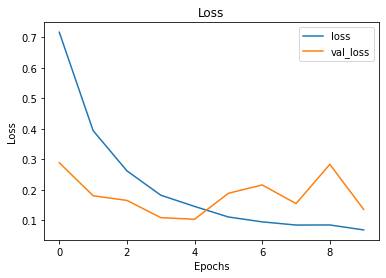

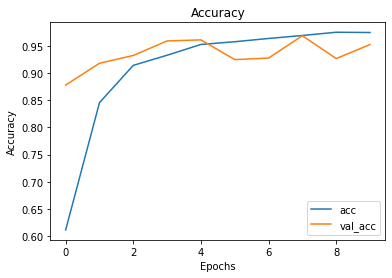

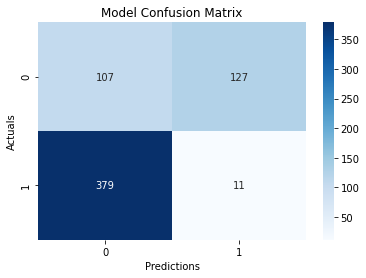

              precision    recall  f1-score   support

           0       0.22      0.46      0.30       234
           1       0.08      0.03      0.04       390

    accuracy                           0.19       624
   macro avg       0.15      0.24      0.17       624
weighted avg       0.13      0.19      0.14       624



20/20 [==============================] - 0s 15ms/step - loss: 0.7634 - acc: 0.8109
Test Loss: 0.7633739113807678
Test Acc: 0.8108974099159241


In [ ]:
evaluate_results(results)

**Evaluation**

This did improve the model quite a bit. When we look at the classification report and the confusion matrix, we can see that this model is predicting the normal xrays very well. There are only a few test images that are normal that are misclassified by the model as having pneumonia (False Positives). On the other hand, it is still having trouble identifying the pneumonia photos. There are lots of False Negatives (images with pneumonia that are misclassified as normal). To try to fix this problem, I will continue to iterate on this model to improve the accuracy.

# Iteration 5

- In this iteration, I will deepen the neural network to include more layers to hopefully pull more features out of the images to improve the model

In [ ]:
mod5 = models.Sequential()

mod5.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod5.add(Conv2D(32, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Conv2D(32, (3, 3), activation='relu'))
mod5.add(Conv2D(32, (3, 3), activation='relu'))
mod5.add(MaxPooling2D(2, 2))

mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Conv2D(128, (3, 3), activation='relu'))
mod5.add(Conv2D(128, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Flatten())
mod5.add(Dense(128, activation='relu'))
mod5.add(Dense(64, activation='relu'))
mod5.add(Dense(1, activation='sigmoid'))

mod5.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
results = mod5.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])

Epoch 1/50
131/131 [==============================] - 7s 53ms/step - loss: 0.7425 - acc: 0.4957 - val_loss: 0.6800 - val_acc: 0.7759
Epoch 2/50
131/131 [==============================] - 7s 51ms/step - loss: 0.6746 - acc: 0.6326 - val_loss: 0.5520 - val_acc: 0.7854
Epoch 3/50
131/131 [==============================] - 7s 52ms/step - loss: 0.4015 - acc: 0.8322 - val_loss: 0.1848 - val_acc: 0.9282
Epoch 4/50
131/131 [==============================] - 7s 52ms/step - loss: 0.2551 - acc: 0.8996 - val_loss: 0.3213 - val_acc: 0.8716
Epoch 5/50
131/131 [==============================] - 7s 51ms/step - loss: 0.2027 - acc: 0.9173 - val_loss: 0.1143 - val_acc: 0.9559
Epoch 6/50
131/131 [==============================] - 7s 52ms/step - loss: 0.1808 - acc: 0.9360 - val_loss: 0.7508 - val_acc: 0.6954
Epoch 7/50
131/131 [==============================] - 7s 52ms/step - loss: 0.1427 - acc: 0.9408 - val_loss: 0.1906 - val_acc: 0.9272
Epoch 8/50
131/131 [==============================] - 7s 52ms/step - 

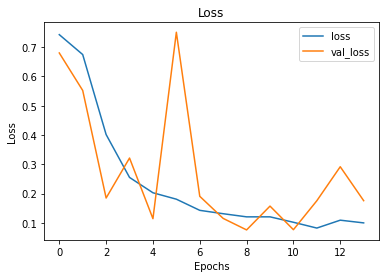

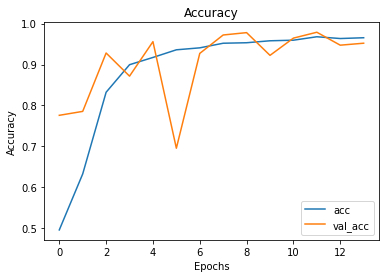

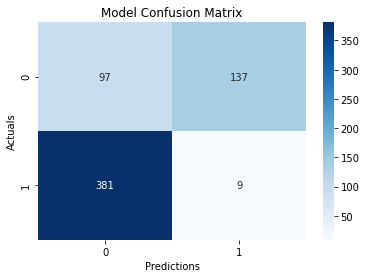

              precision    recall  f1-score   support

           0       0.20      0.41      0.27       234
           1       0.06      0.02      0.03       390

    accuracy                           0.17       624
   macro avg       0.13      0.22      0.15       624
weighted avg       0.11      0.17      0.12       624



20/20 [==============================] - 0s 16ms/step - loss: 0.9561 - acc: 0.8301
Test Loss: 0.9560552835464478
Test Acc: 0.8301281929016113


In [ ]:
evaluate_results(results)

**Evaluation**

The accuracy is slowly improving here. We still have the issue of lots of False Negatives, but I will try to improve this with another strategy--Transfer Learning.

# Iteration 6 and 7: Using Transfer Learning

- The disadvantage of using deep learning is that sometime you don't have a big enough training set to make a very robust model. However, keras allows us to use models that have been pre-trained on millions of images as a base layer
  - In this iteration I will use the VGG19 model as my base and add my own layers on top to see if this improves my model's performance
- I will try 2 different methods

In [ ]:
# Load our VGG19 model as our base
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3))

In [ ]:
mod6 = models.Sequential()
mod6.add(cnn_base)
mod6.add(Flatten())
mod6.add(Dense(128, activation='relu'))
mod6.add(Dense(1, activation='sigmoid'))

In [ ]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Check which layers can be frozen
for layer in mod6.layers:
  print(layer.name, layer.trainable)

print(len(mod6.trainable_weights))

vgg19 True
flatten_19 True
dense_44 True
dense_45 True
36


In [ ]:
# Freeze the model
cnn_base.trainable = False

In [ ]:
# Double check that it has been frozen
for layer in mod6.layers:
  print(layer.name, layer.trainable)

print(len(mod6.trainable_weights))

vgg19 False
flatten_19 True
dense_44 True
dense_45 True
4


In [ ]:
mod6.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
mod6.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_19 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 23,235,905
Trainable params: 3,211,521
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
results = mod6.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])

Epoch 1/50
131/131 [==============================] - 12s 94ms/step - loss: 0.7390 - acc: 0.8514 - val_loss: 0.0734 - val_acc: 0.9693
Epoch 2/50
131/131 [==============================] - 12s 93ms/step - loss: 0.2264 - acc: 0.9310 - val_loss: 0.0596 - val_acc: 0.9789
Epoch 3/50
131/131 [==============================] - 12s 93ms/step - loss: 0.1725 - acc: 0.9389 - val_loss: 0.0452 - val_acc: 0.9828
Epoch 4/50
131/131 [==============================] - 12s 93ms/step - loss: 0.1360 - acc: 0.9547 - val_loss: 0.0440 - val_acc: 0.9837
Epoch 5/50
131/131 [==============================] - 12s 93ms/step - loss: 0.0946 - acc: 0.9650 - val_loss: 0.0428 - val_acc: 0.9847
Epoch 6/50
131/131 [==============================] - 12s 93ms/step - loss: 0.0972 - acc: 0.9652 - val_loss: 0.0473 - val_acc: 0.9828
Epoch 7/50
131/131 [==============================] - 12s 93ms/step - loss: 0.0740 - acc: 0.9722 - val_loss: 0.0402 - val_acc: 0.9847
Epoch 8/50
131/131 [==============================] - 12s 93ms

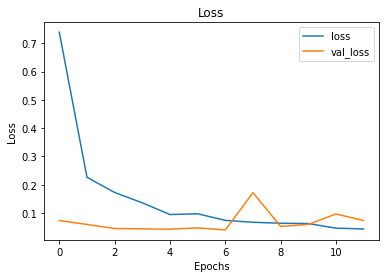

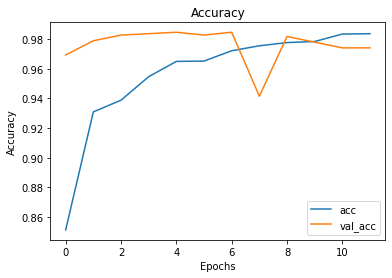

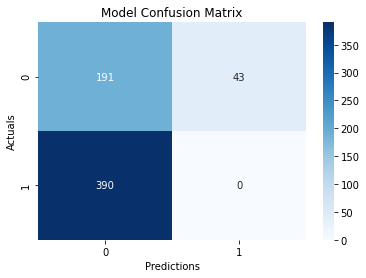

              precision    recall  f1-score   support

           0       0.33      0.82      0.47       234
           1       0.00      0.00      0.00       390

    accuracy                           0.31       624
   macro avg       0.16      0.41      0.23       624
weighted avg       0.12      0.31      0.18       624



20/20 [==============================] - 1s 69ms/step - loss: 2.6838 - acc: 0.6939
Test Loss: 2.68383526802063
Test Acc: 0.6939102411270142


In [ ]:
evaluate_results(results)

## Try another method
- include_top = True

In [ ]:
mod7 = models.Sequential()
cnn_base2 = VGG19(weights='imagenet', include_top = True)
cnn_base2.trainable = False
mod7.add(cnn_base2)
mod7.add(Flatten())
mod7.add(Dense(64, activation='relu'))
mod7.add(Dense(1, activation='sigmoid'))
mod7.compile(optimizer='RMSprop',
             loss='binary_crossentropy',
             metrics=['acc'])

574717952/574710816 [==============================] - 16s 0us/step


In [ ]:
cnn_base2.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
results = mod7.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])

Epoch 1/50
131/131 [==============================] - 13s 96ms/step - loss: 0.6958 - acc: 0.5765 - val_loss: 0.6826 - val_acc: 0.8084
Epoch 2/50
131/131 [==============================] - 12s 95ms/step - loss: 0.6817 - acc: 0.6450 - val_loss: 0.6651 - val_acc: 0.8132
Epoch 3/50
131/131 [==============================] - 12s 95ms/step - loss: 0.6618 - acc: 0.7308 - val_loss: 0.6346 - val_acc: 0.8324
Epoch 4/50
131/131 [==============================] - 12s 95ms/step - loss: 0.6351 - acc: 0.7764 - val_loss: 0.6211 - val_acc: 0.7921
Epoch 5/50
131/131 [==============================] - 12s 95ms/step - loss: 0.6042 - acc: 0.7857 - val_loss: 0.6074 - val_acc: 0.7500
Epoch 6/50
131/131 [==============================] - 12s 95ms/step - loss: 0.5728 - acc: 0.7943 - val_loss: 0.5664 - val_acc: 0.7921
Epoch 7/50
131/131 [==============================] - 12s 95ms/step - loss: 0.5427 - acc: 0.8051 - val_loss: 0.5221 - val_acc: 0.8161
Epoch 8/50
131/131 [==============================] - 12s 95ms

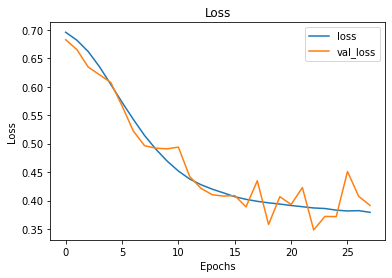

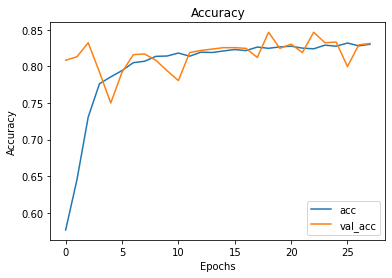

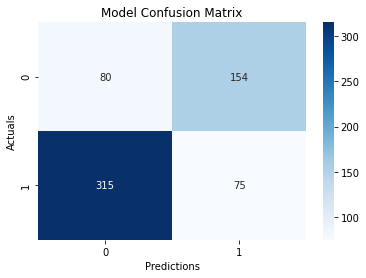

              precision    recall  f1-score   support

           0       0.20      0.34      0.25       234
           1       0.33      0.19      0.24       390

    accuracy                           0.25       624
   macro avg       0.27      0.27      0.25       624
weighted avg       0.28      0.25      0.25       624



20/20 [==============================] - 1s 70ms/step - loss: 0.5341 - acc: 0.7516
Test Loss: 0.5340835452079773
Test Acc: 0.7516025900840759


In [ ]:
evaluate_results(results)

**Evaluation**

Interestingly, these models did not perform better than the 5th iteration (without Transfer Learning). With more fine-tuning and unfreezing certain layers. However, the 7th iteration had a much more balanced confusion matrix (more even False Positive and False Negatives) than past iterations.

# Which is the best model?

**Defining 'Best' for this Use-Case:**

In the case of diagnosing pneumonia, we want to reduce the number of False Negatives. Why? It is better to falsely label someone as having pneumonia (False Positive), than misclassifying someone who is actually sick who will then go untreated (False Negative). However, we would not want too many false positives either because we wouldn't want to prescribe steroids or antibiotics to patients that did not need it. In this use-case, even with the model's prediction, the x-ray will be looked over with human eyes before making a final diagnosis. Therefore, we want want the overall accuracy of the model to be high to make this process the most efficient for the technician or doctor reviewing the x-ray. The more accurate the model, the less time they need to spend in review.

**Best Model**

When we look at all the models, model 5 has the best accuracy (over 80%), and less False Negatives than most of the other models. 

**Final Selection**

For this reason, I think the best model for this use-case is model 5, which reduces False Negatives better than any other model, and still does not have maany False Positives. Model 5 has an accuracy score of 82%, and the lowest number of False Negatives AND False Positives. Therefore, it is an overall better model than any of the previous iterations. 

In [ ]:
# Save Model 5 as final model
final_cnn_path = '/content/drive/MyDrive/final_pre_trained_cnn.hd5'

mod5.save(final_cnn_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/final_pre_trained_cnn.hd5/assets


In [ ]:
# Reload model
final_model = models.load_model(final_cnn_path)

# Look at the Model Explanations
- Look at the features of the image that are contributing to its class prediction


True Class: 0.0
Predicted Class: 0


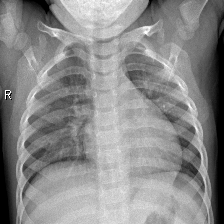

In [ ]:
# Get random image and label
label = y_train[0]
img = X_train[0]

# Get model pred
pred = mod5.predict(np.array([img]))
pred_class = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label)
print('Predicted Class:', pred_class)
array_to_img(img)

In [ ]:
# Make an explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, mod5.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

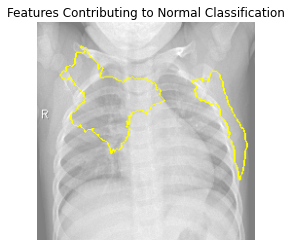

In [ ]:
# Display features contributing to the pneumonia classification
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('Features Contributing to Normal Classification')
plt.show()

True Class: 1.0
Predicted Class: 0


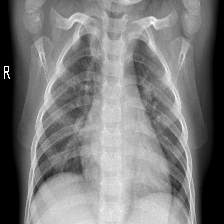

In [ ]:
# Do the same with image at index 2
label2 = y_train[1]
img2 = X_train[1]

# Get model pred
pred2 = mod5.predict(np.array([img2]))
pred_class2 = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label2)
print('Predicted Class:', pred_class2)
array_to_img(img2)

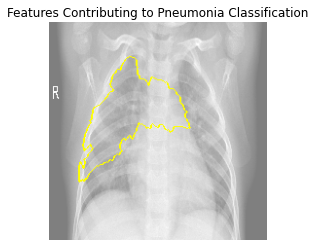

In [ ]:
explanation2 = explainer.explain_instance(img2, mod5.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

temp2, mask2 = explanation2.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
plt.axis('off')
plt.title('Features Contributing to Pneumonia Classification')
plt.show()

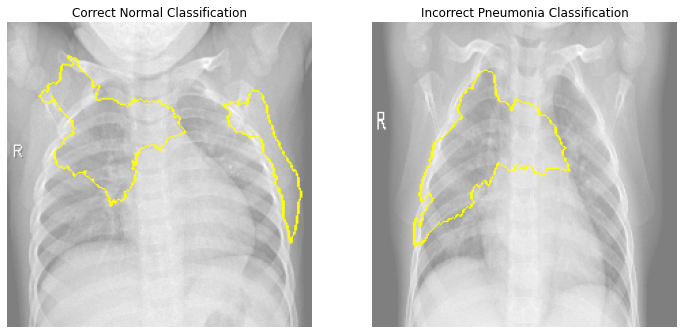

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
axes[1].imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Correct Normal Classification')
axes[1].set_title('Incorrect Pneumonia Classification')
plt.show()

# Recommendations

- Use this model as a tool for efficiency. Implementing this model in a radiology setting as way to assist x-ray technicians in detecting pneumonia would be the best way to use this technology. For example, once the chest x-ray is taken, it can automatically give its prediction to the tech. The tech and/or doctor would then need less time to review the model's prediction and use their trained eye for a final diagnosis. This would speed up the efficiency of the entire department so that the doctors' and techs' time can be mostly spent on other tasks.

- The model will likely work better if the x-ray technician crops out the diaphragm before feeding the image to the model to remove noise. 

- I would also recommend the x-ray tech saves the image as 224 x 224 px before feeing the image into the model.

# Future Work

Since this model has a lot of room for improvement, some future work could include:

- try to retrain the model using smaller images (ex. 64x64 px or 32x32 px)
- look at more preprocessing methods to remove the diaphragm and thus remove noise
- freeze and unfreeze specific layers of the transfer learning models to fine-tune them
- do more research on other methods to tune cnns specifically with chest x-ray/pneumonia classification